In [1]:
from netin.models import DPAHModel

In [19]:
from multiprocessing import Pool, cpu_count
from typing import Dict, List, Set
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from src.seed import (seed_degree, 
    seed_polarized, 
    seed_random, 
    seed_polarized_centrality_mixed, 
    seed_polarized_centrality, 
    seed_polarized_degree, 
    seed_centrality_mixed, 
    seed_centrality, 
    seed_influence_maximization
)


from evaluation import evaluate_all_seeds

In [3]:
N = 200 # Number of total nodes
f_m = 0.3 # Fraction of minority nodes
h = 0.9 # Homophilic
d = 0.05 # desity of the graph
plo = 2.1
#final number of edges will be: e = d * n (n-1)

In [4]:
dpa_model = DPAHModel(N=N, f_m=f_m, d=d, plo_M=plo, plo_m=plo, h_M=h, h_m=h, seed=12345)
dpa_graph = dpa_model.simulate()

In [5]:
G = dpa_graph.to_nxgraph() # This creates a copy of the graph

for node, attr in G.nodes(data=True):
    attr['color'] = attr.pop('minority')

for node in G.nodes():
        in_degree = G.in_degree(node)
        for neighbor in G.successors(node):
            G[node][neighbor]["weight"] = 1 / (2 * in_degree) if in_degree > 0 else 1

In [6]:
seed_size = G.number_of_nodes() // 40
print(f"Seed size: {seed_size}")
max_iter = 1000

Seed size: 5


In [ ]:
k_values = [1,3,5,7,10,15,20]

seed_functions = {
        "Random": seed_random(G, seed_size),
        "MIA": seed_influence_maximization(G, seed_size, 500, 8, 0),
        "Degree": seed_degree(G, seed_size),
        "Centrality": seed_centrality(G, seed_size),
        "Centrality Mixed": seed_centrality_mixed(G, seed_size),
        "Polarized": seed_polarized(G, seed_size, 0),
        "Polarized Degree": seed_polarized_degree(G, seed_size, 0),
        "Polarized Centrality": seed_polarized_centrality(G, seed_size, 0),
        "Polarized Centrality Mixed": seed_polarized_centrality_mixed(G, seed_size, 0),
    }

for k in k_values:
    print(f"K: {k}")
    budget = 2 * k


    # Example of how to call the function
    all_results_df = evaluate_all_seeds(G, seed_functions, k, max_iter, budget, "netin_09_2000", verbose=False)

    all_results_df.to_csv(f"results/test/results_netin_{N}_nodes_{h}_hvalue_{d}_density_{k}_k_{budget}_budget.csv", index=False)

In [13]:
directory = 'results/test/'  # Adjust the path if needed

# Dictionary to store k values and corresponding dataframes
k_dict = {}

# Iterate over all the files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):  # assuming the files are in CSV format
        # Extract the k value from the filename (assuming k is before "_budget")
        try:
            k_value = filename.split("_k_")[0].split("_")[-1]
            k_value = int(k_value)
        except (IndexError, ValueError):
            print(f"Filename {filename} does not match the expected pattern.")
            continue
        
        # Read the CSV file into a DataFrame
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        
        # Store the DataFrame in the dictionary with k as the key
        k_dict[k_value] = df[["Seed Function", "Graph Modification", "Avg Activated Nodes"]]

In [16]:
# Assuming 'k_dict' is the dictionary with k values as keys and dataframes as values
dfs = []

# Iterate over the dictionary and add 'k' as a new column in each dataframe
for k, df in k_dict.items():
    df['k'] = k  # Add 'k' column to each dataframe
    dfs.append(df)  # Append the dataframe to the list

# Concatenate all the dataframes into one combined dataframe
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
else:
    raise ValueError("No dataframes available to concatenate.")

# Now combined_df contains all the data from the different k values

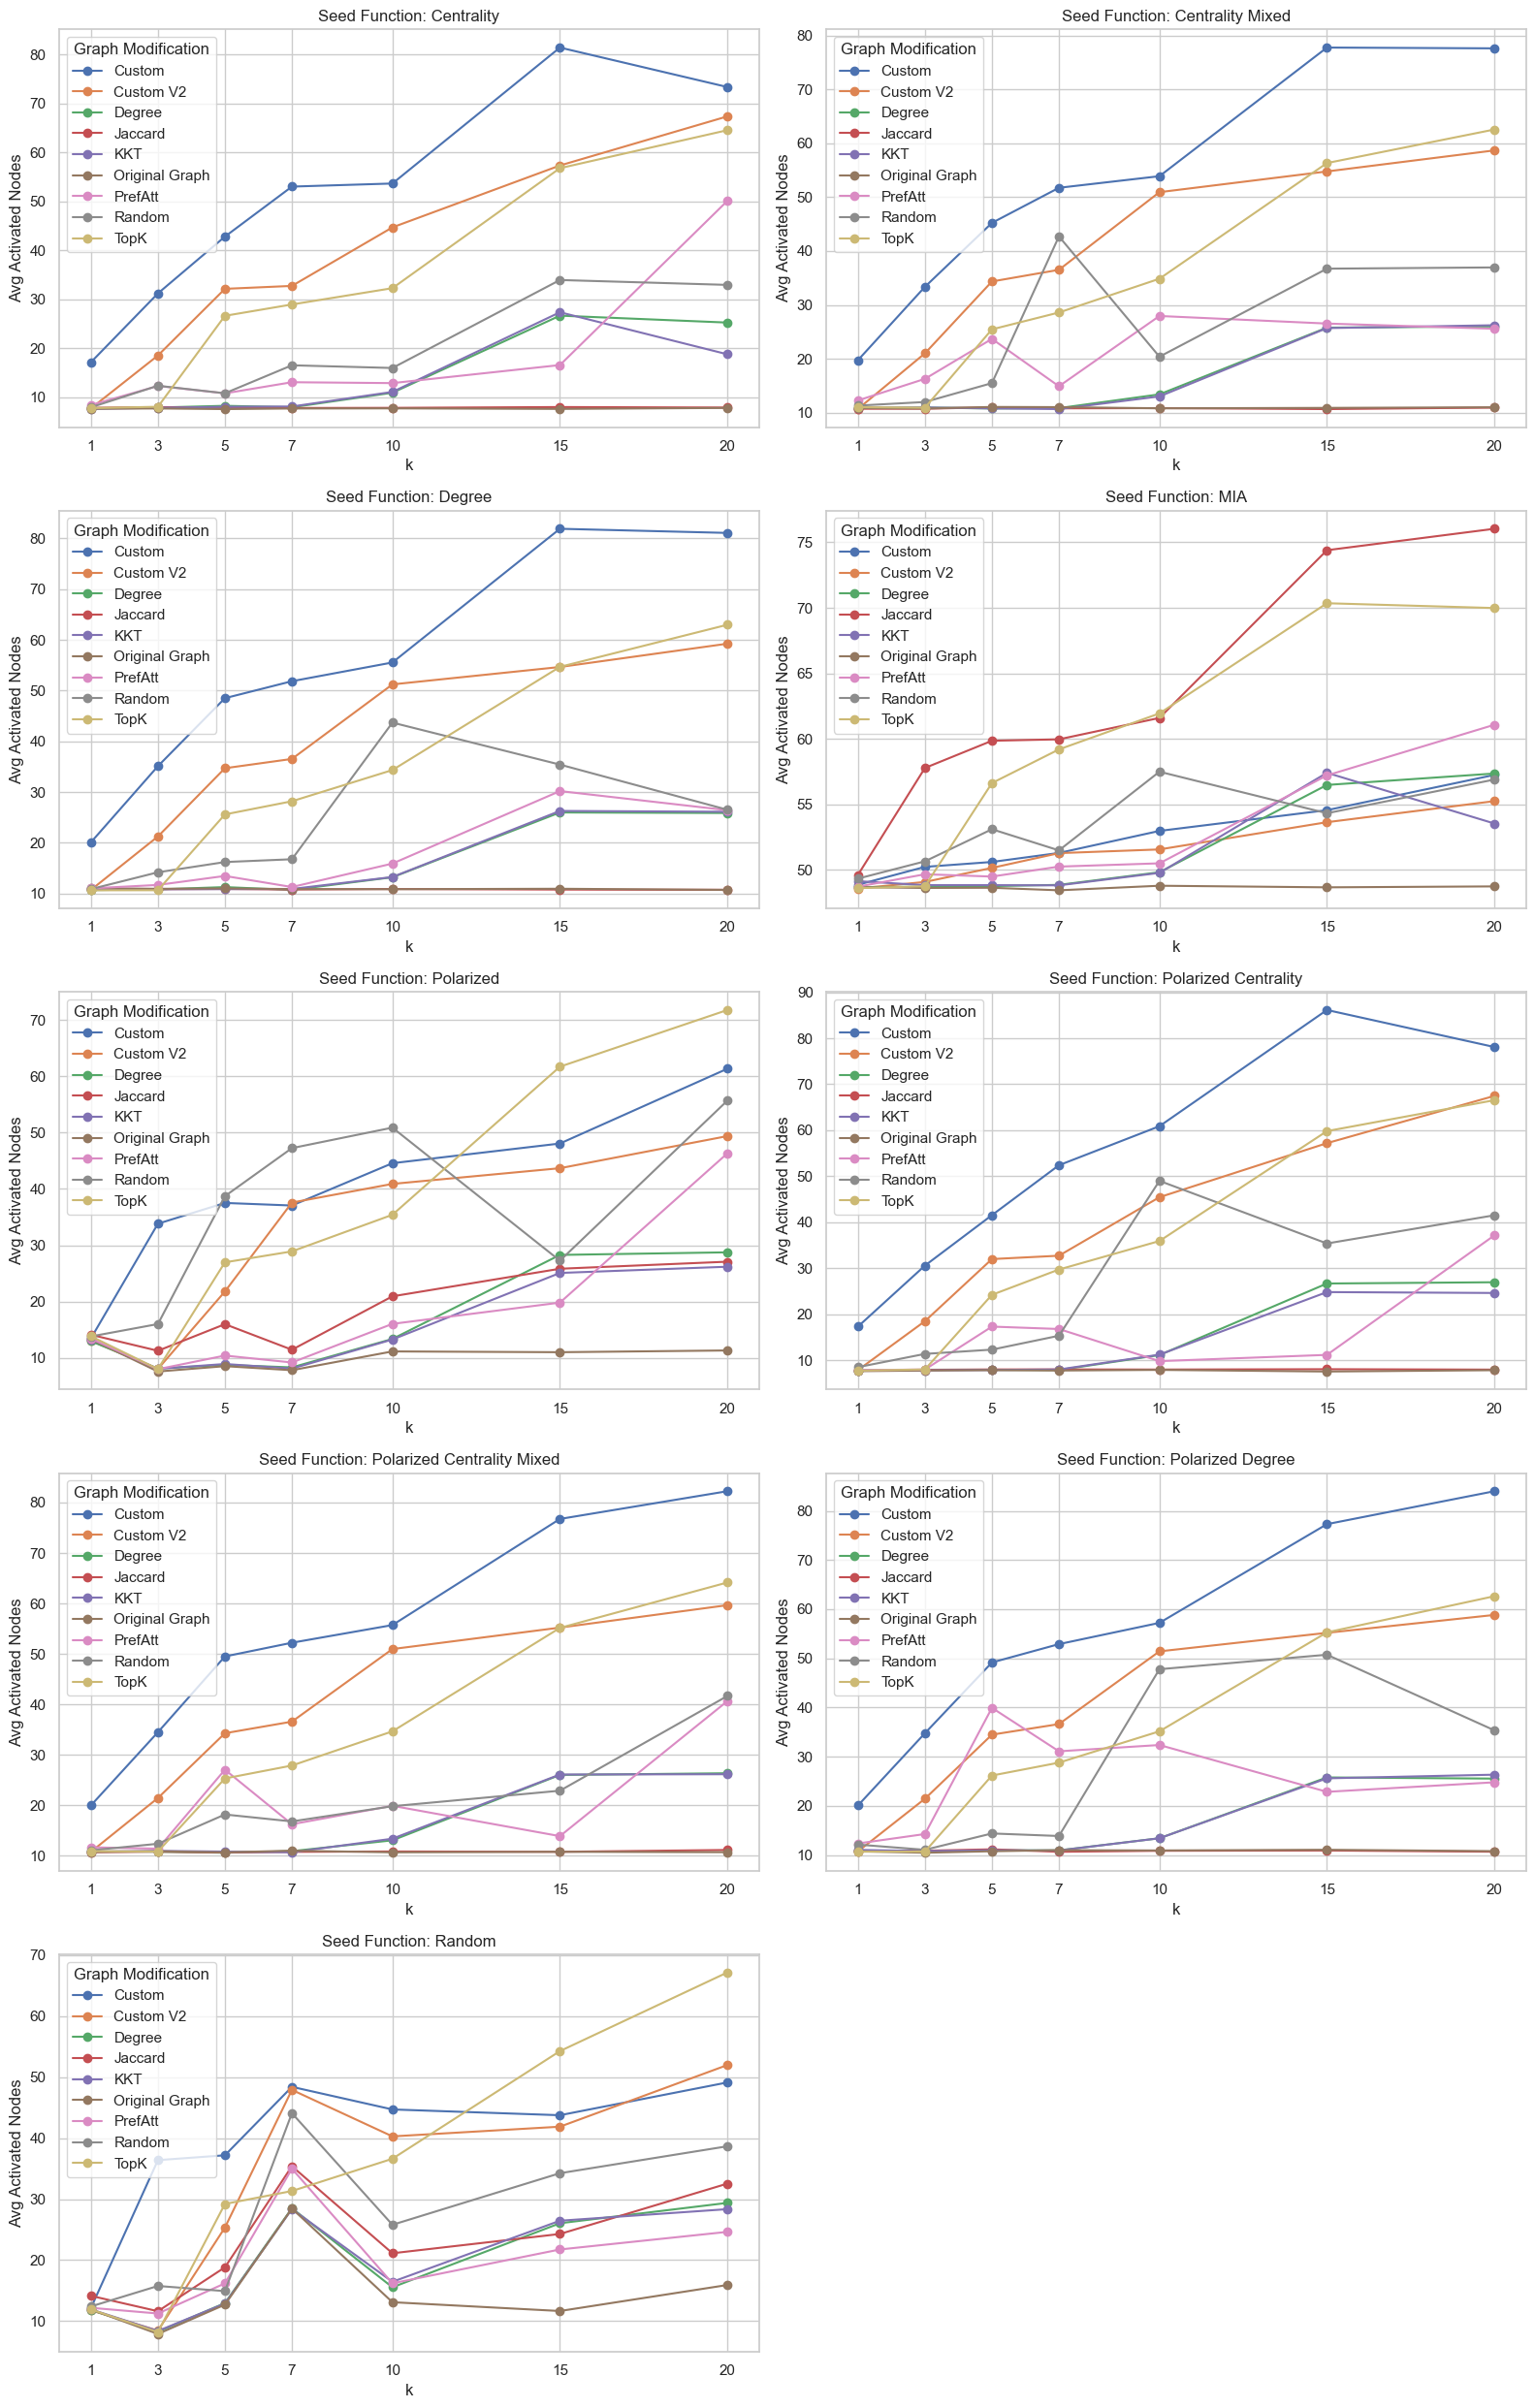

In [24]:
# Ensure that seaborn style is applied for better visuals (optional)
sns.set(style="whitegrid")

# Get the unique seed functions
seed_functions = combined_df['Seed Function'].unique()

# Set up the number of rows and columns for the grid (e.g., 2 columns, adjust based on number of seed functions)
num_seed_functions = len(seed_functions)
cols = 2
rows = math.ceil(num_seed_functions / cols)

# Create subplots with a grid layout
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 5))  # Adjust the size as needed

# Flatten axes array for easier indexing (in case of a 2D array)
axes = axes.flatten()

# Iterate over each seed function and create a plot in the grid
for i, seed_function in enumerate(seed_functions):
    # Filter the dataframe for the current seed function
    seed_df = combined_df[combined_df['Seed Function'] == seed_function]
    
    # Create a pivot table to have 'k' on the x-axis and 'Avg Activated Nodes' on the y-axis
    pivot_table = seed_df.pivot_table(index='k', columns='Graph Modification', values='Avg Activated Nodes')
    
    # Reindex the pivot table to ensure all k values from k_values are used (fill missing values with NaN)
    pivot_table = pivot_table.reindex(k_values)

    # Plot each Graph Modification as a line on the corresponding subplot
    pivot_table.plot(marker='o', ax=axes[i], title=f"Seed Function: {seed_function}")
    
    # Add labels and legend
    axes[i].set_xlabel("k")
    axes[i].set_ylabel("Avg Activated Nodes")
    axes[i].legend(title="Graph Modification")
    
    # Ensure the x-axis only shows the exact k_values
    axes[i].set_xticks(k_values)

# Hide any unused axes (if there are any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Removes the axis completely, leaving white space

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the grid of plots
plt.show()